---
# Severity Classification of Alzheimer's Disease Using MRI Images
## Jason Lu, Juan Marcucci, Dan Rossetti
---
---

# NOTEBOOK 3 - Pre-Trained Models
Notebook Summary:

This notebook seeks to determine if pre-trained models can produce better results when attempting to classify the different classes of brain scans.

---
---

#  WARNING:  NOTEBOOK MUST BE RUN IN GOOGLE COLAB

Due to the computational demands of the convolutional neural networks used in this model requiring GPUs, this project was created entirely on Google Colab.

Further, the data are imported by cloning the Github repo where all of the project materials are stored into Google Colab so that the code can be run anywhere with the relative paths in this notebook.  With that, these relative paths will not work outside of Google Colab.

---
---

# 0 - Imports

In [ ]:
# Basic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Every method known to set random seeds (from the following sources):
# Help with this import:  https://www.tensorflow.org/tutorials/quickstart/advanced
import random
import tensorflow as tf
seed = 42
# Source provided by Eric Bayless for help with this:  
#  https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
tf.keras.utils.set_random_seed(seed)
random.seed(seed)
np.random.seed(seed)
# Help with code below from:  https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed)

# TensorFlow imports
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing

# Evaluation imports
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

# Pre-Trained Models:
#EffieicntNetB0:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# VGG Models:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import VGG19, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input

# InceptionV3:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# 1 - Connect to Github, Read Data
These are the same steps as perfomred in all other notebooks to gather the data.

As they have been previously established and commented, they are combined into a single cell for space and notebook readability.

In [ ]:
# Clear out the directory in case the code is re-run top to bottom.
!rm -r ga_project_4/

# Inspiration to do this from:  https://stackoverflow.com/questions/65386157/importing-images-from-github-to-colab
# Code help from:  https://neptune.ai/blog/google-colab-dealing-with-files
!git clone https://github.com/drossDS/ga_project_4.git

# Help with this code to cd into folders from:  
#  https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter
%cd ga_project_4/
%cd data/

# Unzip data
!unzip -q archive.zip

rm: cannot remove 'ga_project_4/': No such file or directory
Cloning into 'ga_project_4'...
remote: Enumerating objects: 6488, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 6488 (delta 23), reused 45 (delta 16), pack-reused 6424
Receiving objects: 100% (6488/6488), 157.10 MiB | 14.49 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/ga_project_4
/content/ga_project_4/data


# 2 - Create Training and Validation Datasets, Import Testing Dataset
The code below is the same code used in notebooks 1 through 3 to import the data for multi-class classification

In [ ]:
# Create the training dataset using a 80/20 train/validation split
train_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/train',
    image_size = (208, 176),
    batch_size = 32,
    seed = 42,
    validation_split = 0.20,
    subset = 'training',
    label_mode = 'categorical',
)

val_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/train',
    image_size = (208, 176),
    batch_size = 32,
    seed = 42,
    validation_split = 0.20,
    subset = 'validation', 
    label_mode = 'categorical',
)

'''
The testing dataset will be imported in a similar manner, but
does not need to be batched or split.  So some of the arguments input
previously will not need to be called.

NOTE:  Below, 'shuffle' must be set to false.  It was discovered that every time
that test_ds is called (even just to extract the target values), different 
values were being provided each time that the extraction was run.  Turning
off shuffle (by setting it to false) proved effective in producing consistent
target values for the testing dataset.
'''
test_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/test',
    image_size = (208, 176),
    label_mode = 'categorical',
    seed = 42,
    shuffle = False
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


# 3 - Modeling - Pre-Trained Models and Transfer Learning
Here, pretrained models are used to implement transfer learning.  These models have been trained on a variety of different image datasets by third parties and come with all of the trained parameters stored in the model.  These will be used to attempt to get better performance on the MRI image data.

## Evaluation Metrics
The primary evaluation metric that will be used is the accuracy.  Aiming for a model with the best possible accuracy is an all-encompassing strategy to target model optimization and for model selection given that this is a multi-class classification model with a primary focus on prediction.

Clinically, the recall (sensitivity) for each class will also need to be examined, particularly for the Very Mild Dementia, Mild Dementia, and Moderate Dementia classes.  Recall will provide a good indication of how much of each class is being properly identified.  This is important when considering that the goal of this model in a medical setting would be to identify dementia so that treatement options can be prescribed.  If recall is low, that would mean that the demential class(es) is not being identified which may prevent patients from receiving treatment.

## 3.1 - Modeling Functions
Below, a variety of functions are created to perform repetetive tasks more efficiently in the code.


In [ ]:
'''
*** THIS FUNCTION IS REQUIRED TO COMPARE PREDICTED CLASSES TO TRUE CLASSES ***

Here a function is being defined which will extract and format the target data from the 
BatchDataset and then format it into an array of numbers that provide the class numbers.

It will optionally convert this to a pandas series for pandas operations (like .value_counts()).
'''

def target_extractor(data_array, series=False):

  # Source for help with the following line of code to extract classes:
  #  https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
  '''
  The list comprehension produces a list which is then turned into a numpy array with concatenate.  Note that
  an array of 1 x 4 arrays is created, with 4 probabilties of belonging to each class.
  '''
  y = np.concatenate([y for x, y in data_array], axis=0)
  
  '''
  The following argument takes the resulting array containing only probabilities of belonging
  to each class, determines which is the largest probability class, and replaces the entire
  1 x 4 array with a number corresponding to the highest probability class.  This soure was
  helpful wiht this:  
  https://stackoverflow.com/questions/68836551/keras-attributeerror-sequential-object-has-no-attribute-predict-classes
  '''
  y = np.argmax(y, axis = 1)

  # Make y a pandas array for when .value_counts needs to be called
  if series == True:
    y = pd.Series(y)

  return y

In [ ]:
'''
Create a function which will plot the final and best training and validation accuracies on a given model.
'''

def acc_printer(model):
  # Print the training and testing accuracies
  print(f"Final Model Accuracy on Training Data:  {model.history['acc'][-1]}")
  print(f"Final Model Accuracy on Validation Data:  {model.history['val_acc'][-1]}")

  print(f"Best Model Accuracy on Training Data:  {model.history['acc'][np.argmax(model.history['acc'])]}")
  print(f"Best Model Accuracy on Validation Data:  {model.history['val_acc'][np.argmax(model.history['val_acc'])]}")

In [ ]:
'''
Create a fucntion which plots confusion matrix and gives accuracy stats
'''

def results_plotter(input_model,
                    result_variable,
                    report = False):
  # Print the training and testing accuracies
  acc_printer(result_variable)

  # Get the model predictions
  preds = input_model.predict(test_ds, verbose = 0)

  # Convert the model predicitons into an array with class values
  preds_arr = np.argmax(preds, axis = 1)
  print(preds_arr.shape)
  preds_arr

  # Create a y_test array from test_ds that can be compared to the predictions
  y_test = target_extractor(test_ds)
  print(y_test.shape)
  y_test

  ConfusionMatrixDisplay.from_predictions(y_test, preds_arr)

  # Help relabeling the axes from:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
  plt.xticks([0,1,2,3], ['mld', 'mod', 'none', 'vmld'])
  plt.yticks([0,1,2,3], ['mld', 'mod', 'none', 'vmld']);
  print(f'Model Accuracy on Test Data: {accuracy_score(y_test, preds_arr)} \n')

  if report == True:
    print(classification_report(y_test, preds_arr, target_names = ['mild', 'moderate', "none", 'very_mild']))

## 3.2 - EfficientNetB0 Model

In [ ]:
# Instantiate EfficientNetB) and make it untrainable to preserve weights
effnet = EfficientNetB0(include_top=False, weights='imagenet')
effnet.trainable = False

16705208/16705208 [==============================] - 2s 0us/step


Epoch 1/20
129/129 [==============================] - 26s 86ms/step - loss: 0.9866 - acc: 0.5399 - val_loss: 0.9844 - val_acc: 0.5479
Epoch 2/20
129/129 [==============================] - 8s 60ms/step - loss: 0.8828 - acc: 0.5924 - val_loss: 0.7863 - val_acc: 0.6201
Epoch 3/20
129/129 [==============================] - 8s 61ms/step - loss: 0.8199 - acc: 0.6261 - val_loss: 0.9345 - val_acc: 0.5752
Epoch 4/20
129/129 [==============================] - 8s 62ms/step - loss: 0.7971 - acc: 0.6366 - val_loss: 0.8150 - val_acc: 0.6084
Epoch 5/20
129/129 [==============================] - 9s 70ms/step - loss: 0.8377 - acc: 0.6244 - val_loss: 0.7737 - val_acc: 0.6367
Epoch 6/20
129/129 [==============================] - 8s 60ms/step - loss: 0.7469 - acc: 0.6683 - val_loss: 0.8763 - val_acc: 0.6055
Epoch 7/20
129/129 [==============================] - 8s 62ms/step - loss: 0.7562 - acc: 0.6600 - val_loss: 0.7377 - val_acc: 0.6602
Epoch 8/20
129/129 [==============================] - 8s 62ms/step -

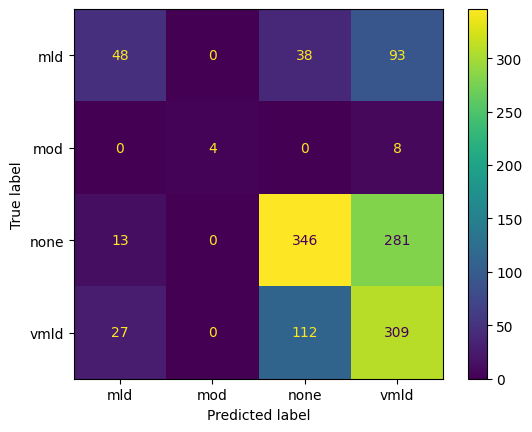

In [ ]:
%%time

# THis model has been adapted from the class notes for transfer learning.
model_effnet = Sequential()
model_effnet.add(effnet)
model_effnet.add(GlobalAveragePooling2D())
model_effnet.add(Dense(4, activation = 'softmax'))

model_effnet.compile(optimizer = Adam(learning_rate = 0.005), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

res_cnn_effnet = model_effnet.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20)

results_plotter(model_effnet, res_cnn_effnet, report = True)

#### OBSERVATIONS:
* EfficientNetB0 has a model accuracy of about 53%
* The model has a difficult time converging with the validation accuracy never going above the low 70s percentage-wise
* The recall values are more balanced between classes (though still coveirng a large range) compared to the manually built models

## 3.3 - VGG19

In [ ]:
%%time

'''
The following sources helped ot establish the code below:
https://www.frontiersin.org/articles/10.3389/fnhum.2023.1150120/full
https://koushik1102.medium.com/transfer-learning-with-vgg16-and-vgg19-the-simpler-way-ad4eec1e2997
https://keras.io/guides/transfer_learning/
https://keras.io/guides/functional_api/
'''

# Early stopping
early_stopping = EarlyStopping(patience=4)

vgg = VGG19(include_top=False, weights='imagenet', input_shape=(208, 176, 3))

# freeze the layers
for layer in vgg.layers:
    layer.trainable = False

# image augmentation
img_aug = Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

inputs = layers.Input(shape=(208, 176, 3))
x = img_aug(inputs)

# pre-process for VGG19

x = preprocess_input(inputs) 

x = vgg(x, training=False)

x = Flatten()(x) 

x = Dense(64, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.5)(x)

outputs = Dense(4, activation = 'softmax')(x)

# Assemble the model
model_vgg19 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_vgg19.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', tf.keras.metrics.AUC(curve='ROC')])

# Fit the model to the data
res_cnn_vgg19 = model_vgg19.fit(train_ds,
                    epochs=20,
                    batch_size=16,
                    validation_data=val_ds,
                    verbose=1,
                    callbacks=[early_stopping])

80134624/80134624 [==============================] - 4s 0us/step
Epoch 1/20
129/129 [==============================] - 26s 157ms/step - loss: 1.1575 - acc: 0.5301 - auc: 0.7698 - val_loss: 1.1192 - val_acc: 0.5674 - val_auc: 0.7805
Epoch 2/20
129/129 [==============================] - 20s 152ms/step - loss: 0.7059 - acc: 0.7154 - auc: 0.9147 - val_loss: 0.5777 - val_acc: 0.7715 - val_auc: 0.9459
Epoch 3/20
129/129 [==============================] - 20s 152ms/step - loss: 0.5166 - acc: 0.7952 - auc: 0.9550 - val_loss: 0.7409 - val_acc: 0.7002 - val_auc: 0.9057
Epoch 4/20
129/129 [==============================] - 21s 159ms/step - loss: 0.4033 - acc: 0.8462 - auc: 0.9728 - val_loss: 0.4146 - val_acc: 0.8408 - val_auc: 0.9710
Epoch 5/20
129/129 [==============================] - 19s 150ms/step - loss: 0.3292 - acc: 0.8802 - auc: 0.9820 - val_loss: 0.4043 - val_acc: 0.8398 - val_auc: 0.9703
Epoch 6/20
129/129 [==============================] - 20s 152ms/step - loss: 0.2838 - acc: 0.8955 - 

Final Model Accuracy on Training Data:  0.922870397567749
Final Model Accuracy on Validation Data:  0.6865234375
Best Model Accuracy on Training Data:  0.9340981245040894
Best Model Accuracy on Validation Data:  0.8408203125
(1279,)
(1279,)
Model Accuracy on Test Data: 0.5488663017982799 

              precision    recall  f1-score   support

        mild       0.27      0.84      0.40       179
    moderate       0.73      0.67      0.70        12
        none       0.81      0.55      0.65       640
   very_mild       0.72      0.43      0.54       448

    accuracy                           0.55      1279
   macro avg       0.63      0.62      0.57      1279
weighted avg       0.70      0.55      0.58      1279



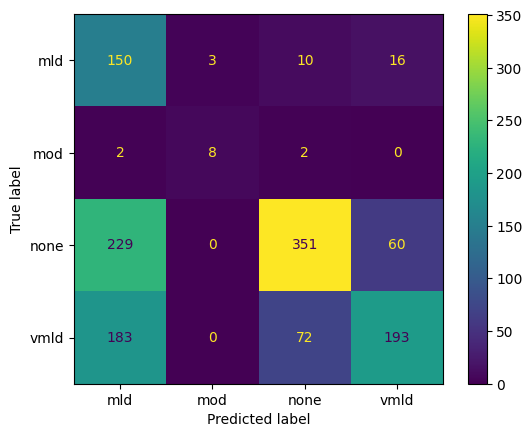

In [ ]:
results_plotter(model_vgg19, res_cnn_vgg19, report = True)

#### OBSERVATIONS:
* VGG19 yields an accuracy of 55%
* The recall values are all above 40% making this one of the better models from a sensitivity standpoint

## 3.4 - VGG16

In [ ]:
%%time

# The sources cited in VGG19 were also used here to establish VGG16

# Early stopping
early_stopping = EarlyStopping(patience=4)

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(208, 176, 3))

# freeze the layers
for layer in vgg.layers:
    layer.trainable = False

# input layer
inputs = layers.Input(shape=(208, 176, 3))

# pre-process for VGG16

x = preprocess_input(inputs) 

x = vgg(x, training=False)

x = Flatten()(x) 

x = Dense(64, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.2)(x)

outputs = Dense(4, activation = 'softmax')(x)

# Assemble the model
model_vgg16 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Fit the model to the data
res_cnn_vgg16 = model_vgg16.fit(train_ds,
                    epochs=20,
                    batch_size=16,
                    validation_data=val_ds,
                    verbose=1,
                    callbacks=[early_stopping])

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/20
129/129 [==============================] - 18s 124ms/step - loss: 0.9946 - acc: 0.6241 - val_loss: 1.6079 - val_acc: 0.5645
Epoch 2/20
129/129 [==============================] - 18s 140ms/step - loss: 0.5297 - acc: 0.8011 - val_loss: 0.5254 - val_acc: 0.7881
Epoch 3/20
129/129 [==============================] - 16s 125ms/step - loss: 0.3448 - acc: 0.8738 - val_loss: 0.5785 - val_acc: 0.7666
Epoch 4/20
129/129 [==============================] - 18s 139ms/step - loss: 0.2183 - acc: 0.9256 - val_loss: 0.4417 - val_acc: 0.8379
Epoch 5/20
129/129 [==============================] - 16s 125ms/step - loss: 0.1709 - acc: 0.9412 - val_loss: 0.4141 - val_acc: 0.8496
Epoch 6/20
129/129 [==============================] - 16s 125ms/step - loss: 0.1478 - acc: 0.9497 - val_loss: 0.4594 - val_acc: 0.8408
Epoch 7/20
129/129 [==============================] - 16s 124ms/step - loss: 0.1010 - acc: 0.9678 - val_loss: 0.3075 - val_ac

Final Model Accuracy on Training Data:  0.9699780344963074
Final Model Accuracy on Validation Data:  0.51171875
Best Model Accuracy on Training Data:  0.9873077869415283
Best Model Accuracy on Validation Data:  0.91015625
(1279,)
(1279,)
Model Accuracy on Test Data: 0.3971853010164191 

              precision    recall  f1-score   support

        mild       0.38      0.18      0.25       179
    moderate       0.00      0.00      0.00        12
        none       0.87      0.07      0.14       640
   very_mild       0.38      0.96      0.54       448

    accuracy                           0.40      1279
   macro avg       0.41      0.30      0.23      1279
weighted avg       0.62      0.40      0.29      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


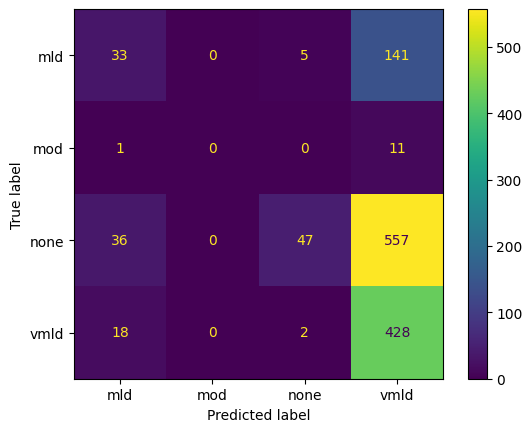

In [ ]:
results_plotter(model_vgg16, res_cnn_vgg16, report = True)

#### OBSERVATIONS:
* VGG19 has a rather low model accuacy of 40%
* This model appears prefer to classify images as very mild dementia and this would explain why the accuracy of this model is so close the percentage of image samples which are in the very mild dementia class with a recall score of 96%

## 3.5 - InceptionV3

In [ ]:
# The following soures were used oto establish this model:
#  https://keras.io/api/applications/inceptionv3/
#  https://cloud.google.com/tpu/docs/inception-v3-advanced

# Early stopping
early_stopping = EarlyStopping(patience=4)

# Function to resize and rescale images
def resize_and_rescale(image, label):
    image = tf.image.resize(image, [299, 299])
    image = preprocess_input(image) 
    return image, label

# Create new datasets for InceptionV3 model
train_ds_inception = train_ds.map(resize_and_rescale)
val_ds_inception = val_ds.map(resize_and_rescale)
test_ds_inception = test_ds.map(resize_and_rescale)


# Load InceptionV3 model
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

# freeze the layers
for layer in inception.layers:
    layer.trainable = False

# input layer
inputs = layers.Input(shape=(299, 299, 3))

# pre-process for InceptionV3
x = preprocess_input(inputs) 

x = inception(x, training=False)

x = Flatten()(x) 

x = Dense(64, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.2)(x)

outputs = Dense(4, activation = 'softmax')(x)

# Assemble the model
model_inception = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Fit the model to the data
res_cnn_inception = model_inception.fit(train_ds_inception,
                    epochs=20,
                    batch_size=16,
                    validation_data=val_ds_inception,
                    verbose=1,
                    callbacks=[early_stopping])

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/20
129/129 [==============================] - 33s 193ms/step - loss: 1.1883 - acc: 0.5563 - val_loss: 1.1121 - val_acc: 0.5371
Epoch 2/20
129/129 [==============================] - 23s 176ms/step - loss: 0.6627 - acc: 0.7435 - val_loss: 0.6255 - val_acc: 0.7510
Epoch 3/20
129/129 [==============================] - 23s 175ms/step - loss: 0.3595 - acc: 0.8809 - val_loss: 0.5198 - val_acc: 0.7832
Epoch 4/20
129/129 [==============================] - 22s 166ms/step - loss: 0.2256 - acc: 0.9275 - val_loss: 0.3410 - val_acc: 0.8711
Epoch 5/20
129/129 [==============================] - 22s 167ms/step - loss: 0.1450 - acc: 0.9609 - val_loss: 0.2490 - val_acc: 0.8994
Epoch 6/20
129/129 [==============================] - 22s 167ms/step - loss: 0.1037 - acc: 0.9736 - val_loss: 0.2138 - val_acc: 0.9287
Epoch 7/20
129/129 [==============================] - 23s 177ms/step - loss: 0.0948 - acc: 0.9729 - val_loss: 0.3633 - val_ac

Final Model Accuracy on Training Data:  0.9909690022468567
Final Model Accuracy on Validation Data:  0.953125
Best Model Accuracy on Training Data:  0.9919453263282776
Best Model Accuracy on Validation Data:  0.966796875
40/40 [==============================] - 9s 190ms/step
(1279,)
(1279,)
Model Accuracy on Test Data: 0.7138389366692729 



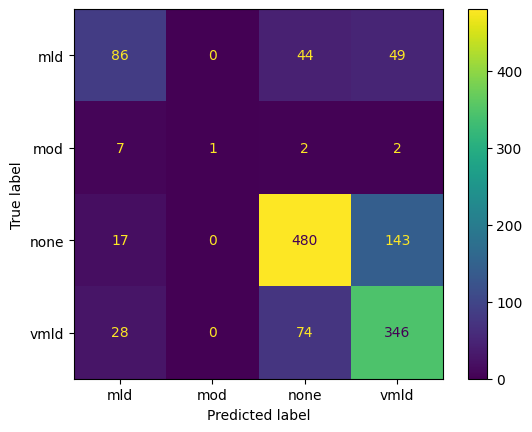

In [ ]:
# Print the training and testing accuracies
acc_printer(res_cnn_inception)
# Get the model predictions
preds = model_inception.predict(test_ds_inception)

# Convert the model predictions into an array with class values
preds_arr = np.argmax(preds, axis = 1)
print(preds_arr.shape)
preds_arr
# Create a y_test array from test_ds that can be compared to the predictions
y_test = target_extractor(test_ds_inception)
print(y_test.shape)
y_test
ConfusionMatrixDisplay.from_predictions(y_test, preds_arr)

# Help relabeling the axes from:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
plt.xticks([0,1,2,3], ['mld', 'mod', 'none', 'vmld'])
plt.yticks([0,1,2,3], ['mld', 'mod', 'none', 'vmld']);
print(f'Model Accuracy on Test Data: {accuracy_score(y_test, preds_arr)} \n')

In [ ]:
print(classification_report(y_test, preds_arr, target_names = ['mild', 'moderate', "none", 'very_mild']))

              precision    recall  f1-score   support

        mild       0.62      0.48      0.54       179
    moderate       1.00      0.08      0.15        12
        none       0.80      0.75      0.77       640
   very_mild       0.64      0.77      0.70       448

    accuracy                           0.71      1279
   macro avg       0.77      0.52      0.54      1279
weighted avg       0.72      0.71      0.71      1279



#### OBSERVATIONS:
* InceptionV3 has a model accuracy of 71%
* Recall scores are varried as almost no moderate dementia images are correctly classified, but the recall scores for the No Dementia and Very Mild Dementia classes are quite strong at 75% and 77% respectively

# Overall Observations
Pre-trained model results are varried depending on the model.  However, InceptionV3 appears to have performed the best with an accuracy of 71%